In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

torch.cuda.empty_cache()

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Hyper parameters
num_epochs = 80
batch_size = 16
learning_rate = 0.001

data_path = './cropped_train/'
data_path_tgt = './cropped_tgt_train/'

data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=data_transform)
train_dataset_tgt = torchvision.datasets.ImageFolder(root=data_path_tgt, transform=data_transform)

print(len(train_dataset))
print(len(train_dataset_tgt))

data_path1 = './test/'

test_dataset = torchvision.datasets.ImageFolder(root=data_path1, transform=data_transform)

print(len(test_dataset))

30000
30000
12


In [4]:
# dataset = torch.utils.data.TensorDataset(train_dataset, train_dataset_tgt)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

train_loader_tgt = torch.utils.data.DataLoader(dataset=train_dataset_tgt,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

In [5]:
class UNet(nn.Module):
    """Custom U-Net architecture for Noise2Noise (see Appendix, Table 2)."""

    def __init__(self, in_channels=3, out_channels=3):
        """Initializes U-Net."""

        super(UNet, self).__init__()

        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=0, output_padding=0))
            
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=0, output_padding=0))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        
        
        self._block7 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))

        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()


    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        pool1 = self._block1(x)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        #print('Encoder 3', pool3.shape)
        pool4 = self._block2(pool3)
        #print('Encoder 4', pool4.shape)
        pool5 = self._block2(pool4)
        #print('Encoder 5', pool5.shape)

        # Decoder
        upsample5 = self._block3(pool5)
        #print('upsample5', upsample5.shape)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        #print('Decoder 5', concat5.shape)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        #print('Decoder 4', concat4.shape)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        #print('Decoder 3', concat3.shape)
        upsample2 = self._block7(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        #print('Decoder 2', concat2.shape)
        upsample1 = self._block7(concat2)
        concat1 = torch.cat((upsample1, x), dim=1)

        # Final activation
        return self._block6(concat1)





model = UNet().to(device)

In [6]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, data in enumerate(zip(train_loader, train_loader_tgt)):
        images = data[0][0].to(device)
        images_tgt = data[1][0].to(device)
        #labels = labels.to(device)
        
        
        # Forward pass
        outputs = model(images)
        outputs_tgt = model(images_tgt)

        loss = criterion(outputs, outputs_tgt)
    
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.12f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # Save the model checkpoint
            if (epoch+1) % 20 == 0 :
                torch.save(model.state_dict(), 'model%d.ckpt' %(epoch+1))
                


Epoch [1/80], Step [100/1875], Loss: 0.000007192819
Epoch [1/80], Step [200/1875], Loss: 0.000002068109
Epoch [1/80], Step [300/1875], Loss: 0.000001855666
Epoch [1/80], Step [400/1875], Loss: 0.000000400647
Epoch [1/80], Step [500/1875], Loss: 0.000000211586
Epoch [1/80], Step [600/1875], Loss: 0.000000083227
Epoch [1/80], Step [700/1875], Loss: 0.000000085569
Epoch [1/80], Step [800/1875], Loss: 0.000000079771
Epoch [1/80], Step [900/1875], Loss: 0.000000138773
Epoch [1/80], Step [1000/1875], Loss: 0.000000033686
Epoch [1/80], Step [1100/1875], Loss: 0.000000040185
Epoch [1/80], Step [1200/1875], Loss: 0.000000013010
Epoch [1/80], Step [1300/1875], Loss: 0.000000018982
Epoch [1/80], Step [1400/1875], Loss: 0.000000030205
Epoch [1/80], Step [1500/1875], Loss: 0.000000035010
Epoch [1/80], Step [1600/1875], Loss: 0.000000016785
Epoch [1/80], Step [1700/1875], Loss: 0.000000032153
Epoch [1/80], Step [1800/1875], Loss: 0.000000009970
Epoch [2/80], Step [100/1875], Loss: 0.000000007347
Epo

Epoch [9/80], Step [1400/1875], Loss: 0.000000000026
Epoch [9/80], Step [1500/1875], Loss: 0.000000000006
Epoch [9/80], Step [1600/1875], Loss: 0.000000000007
Epoch [9/80], Step [1700/1875], Loss: 0.000000000021
Epoch [9/80], Step [1800/1875], Loss: 0.000000000004
Epoch [10/80], Step [100/1875], Loss: 0.000000000002
Epoch [10/80], Step [200/1875], Loss: 0.000000000006
Epoch [10/80], Step [300/1875], Loss: 0.000000000009
Epoch [10/80], Step [400/1875], Loss: 0.000000000003
Epoch [10/80], Step [500/1875], Loss: 0.000000000003
Epoch [10/80], Step [600/1875], Loss: 0.000000000003
Epoch [10/80], Step [700/1875], Loss: 0.000000000002
Epoch [10/80], Step [800/1875], Loss: 0.000000000004
Epoch [10/80], Step [900/1875], Loss: 0.000000000014
Epoch [10/80], Step [1000/1875], Loss: 0.000000000002
Epoch [10/80], Step [1100/1875], Loss: 0.000000000002
Epoch [10/80], Step [1200/1875], Loss: 0.000000000001
Epoch [10/80], Step [1300/1875], Loss: 0.000000000002
Epoch [10/80], Step [1400/1875], Loss: 0.0

Epoch [18/80], Step [600/1875], Loss: 0.000000000000
Epoch [18/80], Step [700/1875], Loss: 0.000000000000
Epoch [18/80], Step [800/1875], Loss: 0.000000000000
Epoch [18/80], Step [900/1875], Loss: 0.000000000000
Epoch [18/80], Step [1000/1875], Loss: 0.000000000000
Epoch [18/80], Step [1100/1875], Loss: 0.000000000000
Epoch [18/80], Step [1200/1875], Loss: 0.000000000000
Epoch [18/80], Step [1300/1875], Loss: 0.000000000000
Epoch [18/80], Step [1400/1875], Loss: 0.000000000001
Epoch [18/80], Step [1500/1875], Loss: 0.000000000000
Epoch [18/80], Step [1600/1875], Loss: 0.000000000000
Epoch [18/80], Step [1700/1875], Loss: 0.000000000003
Epoch [18/80], Step [1800/1875], Loss: 0.000000000000
Epoch [19/80], Step [100/1875], Loss: 0.000000000000
Epoch [19/80], Step [200/1875], Loss: 0.000000000000
Epoch [19/80], Step [300/1875], Loss: 0.000000000000
Epoch [19/80], Step [400/1875], Loss: 0.000000000000
Epoch [19/80], Step [500/1875], Loss: 0.000000000000
Epoch [19/80], Step [600/1875], Loss:

Epoch [26/80], Step [1600/1875], Loss: 0.000000000000
Epoch [26/80], Step [1700/1875], Loss: 0.000000000002
Epoch [26/80], Step [1800/1875], Loss: 0.000000000000
Epoch [27/80], Step [100/1875], Loss: 0.000000000000
Epoch [27/80], Step [200/1875], Loss: 0.000000000000
Epoch [27/80], Step [300/1875], Loss: 0.000000000000
Epoch [27/80], Step [400/1875], Loss: 0.000000000000
Epoch [27/80], Step [500/1875], Loss: 0.000000000000
Epoch [27/80], Step [600/1875], Loss: 0.000000000000
Epoch [27/80], Step [700/1875], Loss: 0.000000000000
Epoch [27/80], Step [800/1875], Loss: 0.000000000000
Epoch [27/80], Step [900/1875], Loss: 0.000000000000
Epoch [27/80], Step [1000/1875], Loss: 0.000000000000
Epoch [27/80], Step [1100/1875], Loss: 0.000000000000
Epoch [27/80], Step [1200/1875], Loss: 0.000000000000
Epoch [27/80], Step [1300/1875], Loss: 0.000000000000
Epoch [27/80], Step [1400/1875], Loss: 0.000000000000
Epoch [27/80], Step [1500/1875], Loss: 0.000000000000
Epoch [27/80], Step [1600/1875], Loss

Epoch [35/80], Step [800/1875], Loss: 0.000000000000
Epoch [35/80], Step [900/1875], Loss: 0.000000000000
Epoch [35/80], Step [1000/1875], Loss: 0.000000000000
Epoch [35/80], Step [1100/1875], Loss: 0.000000000000
Epoch [35/80], Step [1200/1875], Loss: 0.000000000000
Epoch [35/80], Step [1300/1875], Loss: 0.000000000000
Epoch [35/80], Step [1400/1875], Loss: 0.000000000000
Epoch [35/80], Step [1500/1875], Loss: 0.000000000000
Epoch [35/80], Step [1600/1875], Loss: 0.000000000000
Epoch [35/80], Step [1700/1875], Loss: 0.000000000001
Epoch [35/80], Step [1800/1875], Loss: 0.000000000000
Epoch [36/80], Step [100/1875], Loss: 0.000000000000
Epoch [36/80], Step [200/1875], Loss: 0.000000000000
Epoch [36/80], Step [300/1875], Loss: 0.000000000000
Epoch [36/80], Step [400/1875], Loss: 0.000000000000
Epoch [36/80], Step [500/1875], Loss: 0.000000000000
Epoch [36/80], Step [600/1875], Loss: 0.000000000000
Epoch [36/80], Step [700/1875], Loss: 0.000000000000
Epoch [36/80], Step [800/1875], Loss:

Epoch [43/80], Step [1800/1875], Loss: 0.000000000000
Epoch [44/80], Step [100/1875], Loss: 0.000000000000
Epoch [44/80], Step [200/1875], Loss: 0.000000000000
Epoch [44/80], Step [300/1875], Loss: 0.000000000000
Epoch [44/80], Step [400/1875], Loss: 0.000000000000
Epoch [44/80], Step [500/1875], Loss: 0.000000000000
Epoch [44/80], Step [600/1875], Loss: 0.000000000000
Epoch [44/80], Step [700/1875], Loss: 0.000000000000
Epoch [44/80], Step [800/1875], Loss: 0.000000000000
Epoch [44/80], Step [900/1875], Loss: 0.000000000000
Epoch [44/80], Step [1000/1875], Loss: 0.000000000000
Epoch [44/80], Step [1100/1875], Loss: 0.000000000000
Epoch [44/80], Step [1200/1875], Loss: 0.000000000000
Epoch [44/80], Step [1300/1875], Loss: 0.000000000000
Epoch [44/80], Step [1400/1875], Loss: 0.000000000000
Epoch [44/80], Step [1500/1875], Loss: 0.000000000000
Epoch [44/80], Step [1600/1875], Loss: 0.000000000000
Epoch [44/80], Step [1700/1875], Loss: 0.000000000001
Epoch [44/80], Step [1800/1875], Loss

Epoch [52/80], Step [1000/1875], Loss: 0.000000000000
Epoch [52/80], Step [1100/1875], Loss: 0.000000000000
Epoch [52/80], Step [1200/1875], Loss: 0.000000000000
Epoch [52/80], Step [1300/1875], Loss: 0.000000000000
Epoch [52/80], Step [1400/1875], Loss: 0.000000000000
Epoch [52/80], Step [1500/1875], Loss: 0.000000000000
Epoch [52/80], Step [1600/1875], Loss: 0.000000000000
Epoch [52/80], Step [1700/1875], Loss: 0.000000000000
Epoch [52/80], Step [1800/1875], Loss: 0.000000000000
Epoch [53/80], Step [100/1875], Loss: 0.000000000000
Epoch [53/80], Step [200/1875], Loss: 0.000000000000
Epoch [53/80], Step [300/1875], Loss: 0.000000000000
Epoch [53/80], Step [400/1875], Loss: 0.000000000000
Epoch [53/80], Step [500/1875], Loss: 0.000000000000
Epoch [53/80], Step [600/1875], Loss: 0.000000000000
Epoch [53/80], Step [700/1875], Loss: 0.000000000000
Epoch [53/80], Step [800/1875], Loss: 0.000000000000
Epoch [53/80], Step [900/1875], Loss: 0.000000000000
Epoch [53/80], Step [1000/1875], Loss

Epoch [61/80], Step [200/1875], Loss: 0.000000000000
Epoch [61/80], Step [300/1875], Loss: 0.000000000000
Epoch [61/80], Step [400/1875], Loss: 0.000000000000
Epoch [61/80], Step [500/1875], Loss: 0.000000000000
Epoch [61/80], Step [600/1875], Loss: 0.000000000000
Epoch [61/80], Step [700/1875], Loss: 0.000000000000
Epoch [61/80], Step [800/1875], Loss: 0.000000000000
Epoch [61/80], Step [900/1875], Loss: 0.000000000000
Epoch [61/80], Step [1000/1875], Loss: 0.000000000000
Epoch [61/80], Step [1100/1875], Loss: 0.000000000000
Epoch [61/80], Step [1200/1875], Loss: 0.000000000000
Epoch [61/80], Step [1300/1875], Loss: 0.000000000000
Epoch [61/80], Step [1400/1875], Loss: 0.000000000000
Epoch [61/80], Step [1500/1875], Loss: 0.000000000000
Epoch [61/80], Step [1600/1875], Loss: 0.000000000000
Epoch [61/80], Step [1700/1875], Loss: 0.000000000001
Epoch [61/80], Step [1800/1875], Loss: 0.000000000000
Epoch [62/80], Step [100/1875], Loss: 0.000000000000
Epoch [62/80], Step [200/1875], Loss:

Epoch [69/80], Step [1200/1875], Loss: 0.000000000000
Epoch [69/80], Step [1300/1875], Loss: 0.000000000000
Epoch [69/80], Step [1400/1875], Loss: 0.000000000000
Epoch [69/80], Step [1500/1875], Loss: 0.000000000000
Epoch [69/80], Step [1600/1875], Loss: 0.000000000000
Epoch [69/80], Step [1700/1875], Loss: 0.000000000000
Epoch [69/80], Step [1800/1875], Loss: 0.000000000000
Epoch [70/80], Step [100/1875], Loss: 0.000000000000
Epoch [70/80], Step [200/1875], Loss: 0.000000000000
Epoch [70/80], Step [300/1875], Loss: 0.000000000000
Epoch [70/80], Step [400/1875], Loss: 0.000000000000
Epoch [70/80], Step [500/1875], Loss: 0.000000000000
Epoch [70/80], Step [600/1875], Loss: 0.000000000000
Epoch [70/80], Step [700/1875], Loss: 0.000000000000
Epoch [70/80], Step [800/1875], Loss: 0.000000000000
Epoch [70/80], Step [900/1875], Loss: 0.000000000000
Epoch [70/80], Step [1000/1875], Loss: 0.000000000000
Epoch [70/80], Step [1100/1875], Loss: 0.000000000000
Epoch [70/80], Step [1200/1875], Loss

Epoch [78/80], Step [400/1875], Loss: 0.000000000000
Epoch [78/80], Step [500/1875], Loss: 0.000000000000
Epoch [78/80], Step [600/1875], Loss: 0.000000000000
Epoch [78/80], Step [700/1875], Loss: 0.000000000000
Epoch [78/80], Step [800/1875], Loss: 0.000000000000
Epoch [78/80], Step [900/1875], Loss: 0.000000000000
Epoch [78/80], Step [1000/1875], Loss: 0.000000000000
Epoch [78/80], Step [1100/1875], Loss: 0.000000000000
Epoch [78/80], Step [1200/1875], Loss: 0.000000000000
Epoch [78/80], Step [1300/1875], Loss: 0.000000000000
Epoch [78/80], Step [1400/1875], Loss: 0.000000000000
Epoch [78/80], Step [1500/1875], Loss: 0.000000000000
Epoch [78/80], Step [1600/1875], Loss: 0.000000000000
Epoch [78/80], Step [1700/1875], Loss: 0.000000000000
Epoch [78/80], Step [1800/1875], Loss: 0.000000000000
Epoch [79/80], Step [100/1875], Loss: 0.000000000000
Epoch [79/80], Step [200/1875], Loss: 0.000000000000
Epoch [79/80], Step [300/1875], Loss: 0.000000000000
Epoch [79/80], Step [400/1875], Loss:

torch.Size([1, 3, 300, 300])


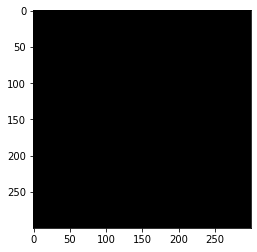

In [11]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
to_img = ToPILImage()
new_model =UNet().to(device)
new_model.load_state_dict(torch.load("model20.ckpt"))



# Test the model
new_model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    
    for images, labels in test_loader:
        images = images.to(device)
        print(images.shape)
        outputs = new_model(images)
        outputs1 = outputs[0]
        outputs1 = outputs1.cpu()
        plt.imshow(to_img(outputs1).convert("RGBA"))
        save_image(outputs1, 'output.png')
        break
        

In [ ]:
from PIL import Image



img = Image.open('2501_tgt_08.png')
trans = transforms.ToPILImage()
trans1 = transforms.ToTensor()
plt.imshow(trans(trans1(img)))